# COVID-19 Outbreak Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geocoder
import folium
from folium import plugins

In [2]:
conf_df = pd.read_csv(r"C:\Users\Dell\Desktop\Machine Learning\COVID-19\csse_covid_19_data\csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [3]:
grouped_conf_df=conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

## Data frame for India

In [4]:
india_df=pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
india_df=india_df.iloc[1:36, :]
state_latitudes=[]
state_longitudes=[]
for i in india_df.index:
    state=india_df["State"][i]
    state_lat = geocoder.osm(state).lat
    state_lng = geocoder.osm(state).lng
    state_latitudes.append(state_lat)
    state_longitudes.append(state_lng)

In [5]:
state_latitudes = pd.Series(data=state_latitudes,index=india_df.index)
state_longitudes=pd.Series(data=state_longitudes,index=india_df.index)
india_df["Latitude"]=state_latitudes
india_df["Longitude"]=state_longitudes

### DataFrame for the US

In [6]:
us_conf_df = pd.read_csv(r"C:\Users\Dell\Desktop\Machine Learning\COVID-19\csse_covid_19_data\csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_conf_df = us_conf_df.dropna()
grouped_us_conf_df = us_conf_df.groupby(by = ['Combined_Key'], as_index = False).sum()

## Function to get total confirmed cases in a country 

In [7]:
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country=conf_df[conf_df['Country/Region']==country_name].iloc[:,4:].apply(sum,axis=0)
    total_cases_country.index=pd.to_datetime(total_cases_country.index)
    return total_cases_country

## Function to get total confirmed cases in the world 

In [8]:
def get_total_conformed_global_cases():
    global_cases=conf_df.iloc[:,4:].apply(sum,axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

## Function to create a line plot 

In [9]:
def line_plot(your_name,plot_background,fig_width,fig_height,country_name,color,linewidth,markertype):
    dt_series=None
    if country_name!="global":
        dt_series=get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series=get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize=(fig_width,fig_height))
    plt.title(f"{country_name.upper()}\nTotal Corona Virus Cases Reported\nCreated By {your_name.upper()}",fontsize=16)
    plt.plot(dt_series.index,dt_series,c=color,lw=linewidth,marker=markertype,markersize=7)
    plt.xticks(rotation=45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle="--",c="grey")
    plt.show()

In [10]:
def add_minimap(map_name):
    minimap=plugins.MiniMap(toggle_display=True)
    map_name.add_child(minimap)
    plugins.ScrollZoomToggler().add_to(map_name)
    plugins.Fullscreen(position='topright').add_to(map_name)

In [11]:
def add_title(map_name,country,your_name):
    title_html = '''
        <h2 align="center" style="font-size:20px"><b>Coronavirus Total Confirmed Cases in {}</b></h2>
        <h4 align="center" style="font-size:16px"><i>Created by</i> {}</h4>
             '''.format(country, your_name.upper())   
    return map_name.get_root().html.add_child(folium.Element(title_html))

## Function to create folium maps using for India, US and the world 

In [12]:
def folium_map_with_circles(your_name,country,map_width,map_height,left_margin,top_margin,map_tile,zoom,circle_color,minimap):
    last_col=conf_df.columns[-1]
    if country=="India":
        india_map=folium.Map(location=[22.3511148, 78.6677428],width=map_width,height=map_height,left=f"{left_margin}%",top=f"{top_margin}%",tiles=map_tile,zoom_start=zoom)
        if minimap==True:
            add_minimap(india_map)
            
        add_title(india_map,country,your_name)
        for i in india_df.index:
            folium.Circle(radius = float(india_df.loc[i, 'Confirmed']) / 10,location = [india_df.loc[i, 'Latitude'], india_df.loc[i, 'Longitude']],popup = "{}\n {}\n on {}".format(india_df.loc[i, 'State'],india_df.loc[i, 'Confirmed'],india_df.loc[i, 'Last_Updated_Time']),color=circle_color,fill = True).add_to(india_map)
        return india_map
    elif country=="US":
        us_map = folium.Map(location = [39.381266, -97.922211],width = map_width, height = map_height, left = f"{left_margin}%", top = f"{top_margin}%",tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(us_map)
            
        add_title(us_map, country, your_name)
        for i in grouped_us_conf_df.index:
            folium.Circle(location = [grouped_us_conf_df.loc[i, 'Lat'], grouped_us_conf_df.loc[i, 'Long_']],radius = int(grouped_us_conf_df.loc[i, last_col]),popup = "{}\n {}\n on {}".format(grouped_us_conf_df.loc[i, 'Combined_Key'], grouped_us_conf_df.loc[i, last_col],last_col),color = circle_color,fill = True).add_to(us_map)
        return us_map
    elif country == 'World':
        world_map = folium.Map(location = [0, 0],width = map_width, height = map_height,left = f"{left_margin}%", top = f"{top_margin}%",tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(world_map)
        
        add_title(world_map, country, your_name)
        for i in grouped_conf_df.index:
            folium.Circle(location = [grouped_conf_df.loc[i, 'Lat'], grouped_conf_df.loc[i, 'Long']], radius = int(grouped_conf_df.loc[i, last_col]) / 10,popup = "{}\n {}\n on {}".format(grouped_conf_df.loc[i, 'Country/Region'],grouped_conf_df.loc[i, last_col],last_col),color = circle_color,fill = True).add_to(world_map)
        return world_map
    else:
        print("\nWrong input! Enter either India, US or World.\n")

In [13]:
grouped_conf_df = conf_df.groupby(by='Country/Region', as_index=False).sum()
desc_grp_conf_df = grouped_conf_df.sort_values(by=conf_df.columns[-1], ascending=False)

In [14]:
def bar_plot(your_name, num_countries, width, height):
    last_col = conf_df.columns[-1]
    latest_date = datetime.datetime.strptime(last_col, '%m/%d/%y').strftime('%B %d, %Y')
    plt.figure(figsize = (width, height))
    plt.title(f'Top {num_countries} Countries with Highest COVID-19 Confirmed Cases\nCreated by {your_name.upper()}',fontsize = 16)
    sns.barplot(desc_grp_conf_df[last_col].head(num_countries), desc_grp_conf_df['Country/Region'].head(num_countries), orient = 'h')
    plt.xlabel(f'Total Confirmed Cases (in millions) as of {latest_date}')
    plt.show()

In [15]:
non_cum_conf_df = desc_grp_conf_df.iloc[:, :4]
for i in range(len(desc_grp_conf_df.columns[3:]) - 1):
    series = desc_grp_conf_df[desc_grp_conf_df.columns[3 + (i + 1) ]] - desc_grp_conf_df[desc_grp_conf_df.columns[3 + i]]
    non_cum_conf_df[desc_grp_conf_df.columns[3 + (i + 1)]] = series

In [16]:
def get_total_daily_confirmed_cases_for_country(country_name):
    total_daily_cases = non_cum_conf_df[non_cum_conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_daily_cases.index = pd.to_datetime(total_daily_cases.index)
    return total_daily_cases

In [17]:
def daily_cases_line_plot(your_name, num_countries, width, height):
    plt.figure(figsize=(width, height))
    plt.title(f'Non-Cumulative COVID-19 Confirmed Cases\nCreated by {your_name.upper()}', fontsize = 16)
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

In [18]:
conf_df [conf_df["Country/Region"]=="India"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
146,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,10512093,10527683,10542841,10557985,10571773,10581823,10595639,10610883,10625428,10639684


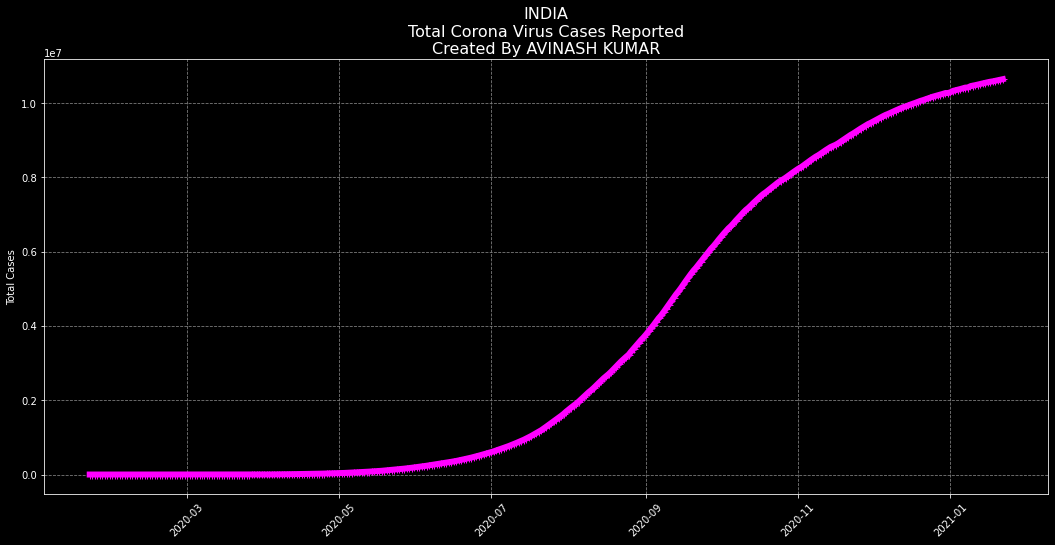

In [19]:
line_plot("Avinash Kumar","dark_background",18, 8, "India","magenta",6,"+")

In [20]:
india_df

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,Migrated_Other,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes,Latitude,Longitude
1,Maharashtra,2006354,1910521,50740,43870,23/01/2021 20:39:52,1223,MH,0,0,0,"[Dec 16]:10,218 duplicate cases & other state ...",18.906836,75.674158
2,Karnataka,935478,915924,12193,7342,23/01/2021 21:51:52,19,KA,0,0,0,NaN,14.520390,75.722352
3,Andhra Pradesh,886852,878232,7147,1473,23/01/2021 20:39:54,0,AP,0,0,0,NaN,15.924091,80.186381
4,Tamil Nadu,834171,816878,12309,4984,23/01/2021 20:39:55,0,TN,0,0,0,[July 22]: 444 backdated deceased entries adde...,10.909433,78.366535
5,Kerala,884243,808377,3588,72051,23/01/2021 21:51:54,227,KL,0,0,0,Mahe native who expired in Kannur included in ...,10.352874,76.512040
6,Delhi,633739,621060,10799,1880,23/01/2021 19:49:58,0,DL,0,0,0,[July 14]: Value for the total tests conducted...,28.651718,77.221939
7,Uttar Pradesh,598445,582506,8609,7330,24/01/2021 02:53:49,0,UP,0,0,0,[Jan 1]:As no bulletin was provided for 31'st ...,27.130334,80.859666
8,West Bengal,567714,551211,10107,6396,23/01/2021 20:39:56,0,WB,0,0,0,NaN,22.996495,87.685588
9,Odisha,334150,330962,1957,1231,24/01/2021 02:53:50,0,OR,0,0,0,[July 12th] :20 non-covid deaths reported in s...,20.543124,84.689732
10,Rajasthan,316485,310279,2758,3448,23/01/2021 21:09:12,0,RJ,0,0,0,NaN,26.810578,73.768455


In [21]:
folium_map_with_circles("Avinash kumar","India",1200,700,12,2,"OpenStreetMap",4,"magenta",True)